<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE7-WEEK1/m07w01_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data

In [ ]:
# Khoa_LHR_image.zip
!gdown --id 1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3
From (redirected): https://drive.google.com/uc?id=1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3&confirm=t&uuid=b878c606-2c38-495e-9009-94d228234b22
To: /content/Khoa_LHR_image.zip
100% 89.0M/89.0M [00:01<00:00, 67.2MB/s]


In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
!unzip /content/Khoa_LHR_image.zip

Archive:  /content/Khoa_LHR_image.zip
   creating: Khoa_LHR_image/
   creating: Khoa_LHR_image/train/
  inflating: Khoa_LHR_image/train/0.png  
  inflating: Khoa_LHR_image/train/1.png  
  inflating: Khoa_LHR_image/train/10.png  
  inflating: Khoa_LHR_image/train/100.png  
  inflating: Khoa_LHR_image/train/101.png  
  inflating: Khoa_LHR_image/train/102.png  
  inflating: Khoa_LHR_image/train/103.png  
  inflating: Khoa_LHR_image/train/104.png  
  inflating: Khoa_LHR_image/train/105.png  
  inflating: Khoa_LHR_image/train/106.png  
  inflating: Khoa_LHR_image/train/107.png  
  inflating: Khoa_LHR_image/train/108.png  
  inflating: Khoa_LHR_image/train/109.png  
  inflating: Khoa_LHR_image/train/11.png  
  inflating: Khoa_LHR_image/train/110.png  
  inflating: Khoa_LHR_image/train/111.png  
  inflating: Khoa_LHR_image/train/112.png  
  inflating: Khoa_LHR_image/train/113.png  
  inflating: Khoa_LHR_image/train/114.png  
  inflating: Khoa_LHR_image/train/115.png  
  inflating: Khoa_LHR_im

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
from torcheval.metrics.functional import peak_signal_noise_ratio
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms

In [ ]:
train_data_path = '/content/Khoa_LHR_image/train'
val_data_path = '/content/Khoa_LHR_image/val'
batch_size = 8
low_img_height = 64
low_img_width = 64

## Unet for super resolution image

### No skip connection

In [ ]:
class FirstFeatureNoskip(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(FirstFeatureNoskip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=out_channels,
                      kernel_size=1,
                      padding=0,
                      stride=1,
                      bias=False),
            nn.LeakyReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class ConvBlockNoSkip(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(ConvBlockNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1,
                      stride=1,
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1,
                      stride=1,
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Encoder_Noskip(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(Encoder_Noskip, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlockNoSkip(input_channels, out_channels)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Decoder_Noskip(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(Decoder_Noskip, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels = input_channels,
                      out_channels = out_channels*2,
                      kernel_size = 1,
                      stride = 1,
                      padding = 0,
                      bias = False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(inplace = True),
        )
        self.conv_block = ConvBlockNoSkip(input_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.conv_block(x)
        return x

In [ ]:
class FinalOutput_Noskip(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(FinalOutput_Noskip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, out_channels, 1, 1, 0, bias = False),
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Unet_NoSkip(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super(Unet_NoSkip, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((low_img_width*4, low_img_height*4),
                                             antialias=True)

        self.first_feature =FirstFeatureNoskip(n_channels, 64)
        self.in_conv1 = ConvBlockNoSkip(64, 64)

        self.encoder1 = Encoder_Noskip(64, 128)
        self.encoder2 = Encoder_Noskip(128,256)
        self.encoder3 = Encoder_Noskip(256,512)
        self.encoder4 = Encoder_Noskip(512,1024)

        self.decoder1 = Decoder_Noskip(1024,512)
        self.decoder2 = Decoder_Noskip(512,256)
        self.decoder3 = Decoder_Noskip(256,128)
        self.decoder4 = Decoder_Noskip(128,64)

        self.final_output = FinalOutput_Noskip(64, n_classes)

    def forward(self, x):
      x = self.resize_fnc(x)
      x = self.first_feature(x)
      x = self.in_conv1(x)

      x = self.encoder1(x)
      x = self.encoder2(x)
      x = self.encoder3(x)
      x = self.encoder4(x)

      x = self.decoder1(x)
      x = self.decoder2(x)
      x = self.decoder3(x)
      x = self.decoder4(x)
      x = self.final_output(x)
      return x


### Skip connection

In [ ]:
class FirstFeature(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=out_channels,
                      kernel_size=1,
                      padding=0,
                      stride=1,
                      bias=False),
            nn.LeakyReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1,
                      stride=1,
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True),
            nn.Conv2d(in_channels=input_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1,
                      stride=1,
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace = True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlock(input_channels, out_channels)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(input_channels = input_channels,
                      out_channels = out_channels*2,
                      kernel_size = 1,
                      stride = 1,
                      padding = 0,
                      bias = False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(inplace = True),
        )
        self.conv_block = ConvBlockNoSkip(input_channels, out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.conv_block(x)
        return x

In [ ]:
class FinalOutput(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, out_channels, 1, 1, 0, bias = False),
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((low_img_width*4, low_img_height*4),
                                             antialias=True)

        self.first_feature = FirstFeature(n_channels, 64)
        self.in_conv1 = ConvBlock(64, 64)


        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128,256)
        self.encoder3 = Encoder(256,512)
        self.encoder4 = Encoder(512,1024)

        self.decoder1 = Decoder(1024,512)
        self.decoder2 = Decoder(512,256)
        self.decoder3 = Decoder(256,128)
        self.decoder4 = Decoder(128,64)

        self.final_output = FinalOutput(64, n_classes)

    def forward(self, x):
      x = self.resize_fnc(x)
      x = self.first_feature(x)
      x1 = self.in_conv1(x)

      x2 = self.encoder1(x1)
      x3 = self.encoder2(x2)
      x4 = self.encoder3(x3)
      x5 = self.encoder4(x4)

      x = self.decoder1(x5, x4)
      x = self.decoder2(x, x3)
      x = self.decoder3(x, x2)
      x = self.decoder4(x, x1)
      x = self.final_output(x)
      return x


## Prepare Super Resolution

### split train Validation data

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.img_dir = img_dir
        self.is_train = is_train
        self.img_paths = os.listdir(img_dir)
        self.resize = transforms.Resize((low_img_width, low_img_height), antialias=True)

    def __len__(self):
        return len(self.img_paths)

    # convert image from (0,1) to (-1,1)
    def normalize(self, input_img, target_img):
        input_img = 2*input_img - 1
        target_img = 2*target_img - 1
        return input_img, target_img

    def random_jitter(self, input_image, target_image):
        if random.random() < 0.5:
            input_image = transforms.functional.hflip(input_image) # Use transforms.functional.hflip
            target_image = transforms.functional.hflip(target_image) # Use transforms.functional.hflip
        return input_image, target_image

    def __getitem__(self, idx):
      # đọc dữ liệu ảnh
        img_path = self.img_paths[idx]
        img = Image.open(os.path.join(self.img_dir, img_path)).convert('RGB')
        img = np.array(img)
        img = transforms.functional.to_tensor(img)

      # thay đổi kích thước và chuyển kiểu dữ liệu
        input_img = self.resize(img).type(torch.float32)
        target_img = img.type(torch.float32)

        input_img, target_img = self.normalize(input_img, target_img)

        if self.is_train:
            input_img, target_img = self.random_jitter(input_img, target_img)
        return input_img, target_img

In [ ]:
train_dataset = ImageDataset(train_data_path, is_train = True)
test_dataset = ImageDataset(val_data_path, is_train = False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Text(0.5, 1.0, 'Target')

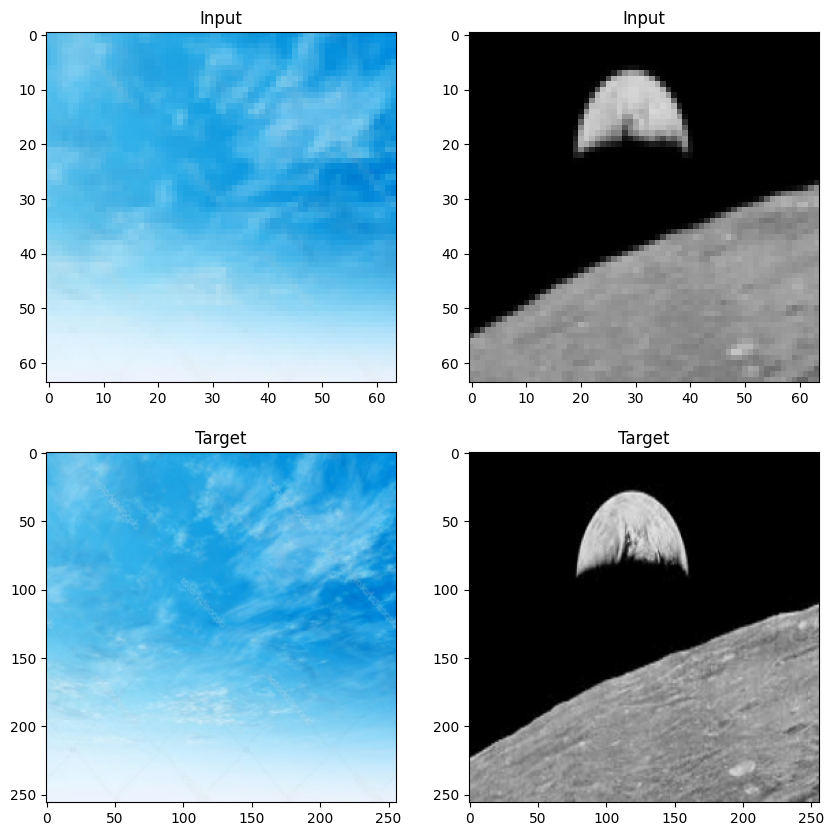

In [ ]:
in_batch, tar_batch = next(iter(train_loader))
in_batch = (in_batch + 1)/2
tar_batch = (tar_batch + 1)/2

plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(in_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(tar_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Target")
ax = plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(in_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(tar_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Target")



In [ ]:
print(in_batch[0].shape)
print(tar_batch[0].shape)

torch.Size([3, 64, 64])
torch.Size([3, 256, 256])


In [ ]:
def generate_images(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
    inputs, labels, predictions = inputs.cpu().numpy(), labels.cpu().numpy(), predictions.cpu().numpy()
    plt.figure(figsize=(15,20))

    display_list = [inputs[-1].transpose((1, 2, 0)), labels[-1].transpose((1, 2, 0)), predictions[-1].transpose((1, 2, 0))]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [ ]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0,
                log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(predictions, labels)
        total_count += 1
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| psnr {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0
            start_time = time.time()

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())


            total_psnr +=  peak_signal_noise_ratio(predictions, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_psnr, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_psnrs.append(train_psnr.cpu())
        train_losses.append(train_loss)

        # Evaluation
        eval_psnr, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_psnrs.append(eval_psnr.cpu())
        eval_losses.append(eval_loss)

        # Save best model
        if best_psnr_eval < eval_psnr :
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            inputs_t, targets_t = next(iter(valid_dataloader))
            generate_images(model, inputs_t, targets_t)
            best_psnr_eval = eval_psnr
        times.append(time.time() - epoch_start_time)
        # Print loss, psnr end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_psnrs, eval_psnrs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_psnrs, label = "Training")
    axs[0].plot(epochs, eval_psnrs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("PSNR")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [ ]:
import matplotlib.pyplot as plt

def predict_and_display(model, test_dataloader, device):
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            if idx >= 10:
                break
            inputs = inputs.to(device)
            predictions = model(inputs)
            generate_images(model, inputs, labels)
            plt.show()




## Unet with No Skip Connection

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model_noskip = Unet_NoSkip().to(device)
SR_unet_model_noskip.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model_noskip.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model_noskip, metrics = train(
    SR_unet_model_noskip, 'SR_unet_model_noskip', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

| epoch   1 |    50/   86 batches | psnr   14.408


In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model_noskip, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model_noskip, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model_noskip, test_loader, device)

##Unet

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model = Unet().to(device)
SR_unet_model.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model, metrics = train(
    SR_unet_model, 'SR_unet_model', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model, test_loader, device)